In [1]:
import geopandas as gpd
import pandas as pd
import re
import networkx as nx
import time
import gensim
import string
import nxviz as nv
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
import xml.etree.ElementTree as et 
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn.manifold import TSNE
Minimum_Sample_Size = 0
pd.options.mode.chained_assignment = None
import warnings 
warnings.filterwarnings(action = 'ignore') 

In [2]:
def load_posts():
    xtree = et.parse("./data/datascience_stackexchange_com/Posts.xml")
    xroot = xtree.getroot() 
    df_cols = ["Id","PostTypeId", "ParentID","AcceptedAnswerId","CreationDate","Score","ViewCount","OwnerUserId","Tags","Title","Body"]
    rows = []
    for x in xroot:
        row = dict()
        for col in df_cols:
            if col in x.attrib:
                row[col] = x.attrib[col]
            else:
                row[col] = None
        rows.append(row)
    user_df = pd.DataFrame(rows, columns = df_cols)
    return user_df

In [3]:
start_time = time.time()

In [4]:
data_posts = load_posts()

In [5]:
data_posts.shape

(39929, 11)

In [6]:
data_posts.head()

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,OwnerUserId,Tags,Title,Body
0,5,1,None,None,2014-05-13T23:58:30.457,8,604,5,<machine-learning>,How can I do simple machine learning without h...,<p>I've always been interested in machine lear...
1,7,1,None,10,2014-05-14T00:11:06.457,4,426,36,<education><open-source>,What open-source books (or other materials) pr...,"<p>As a researcher and instructor, I'm looking..."
2,9,2,None,None,2014-05-14T00:36:31.077,5,None,51,None,None,"<p>Not sure if this fits the scope of this SE,..."
3,10,2,None,None,2014-05-14T00:53:43.273,12,None,22,None,None,"<p>One book that's freely available is ""The El..."
4,14,1,None,29,2014-05-14T01:25:59.677,23,1495,66,<data-mining><definitions>,Is Data Science the Same as Data Mining?,<p>I am sure data science as will be discussed...


In [7]:
data_posts.isnull().any()

Id                  False
PostTypeId          False
ParentID             True
AcceptedAnswerId     True
CreationDate        False
Score               False
ViewCount            True
OwnerUserId          True
Tags                 True
Title                True
Body                False
dtype: bool

In [8]:
data_posts['Tags'].isnull().sum()

21416

In [9]:
dist = dict()
questions_df = data_posts[data_posts['PostTypeId']=='1']
dist['Questions'] = len(questions_df)
answers_df = data_posts[data_posts['PostTypeId']=='2']
dist['Answers'] = len(answers_df)

<BarContainer object of 2 artists>

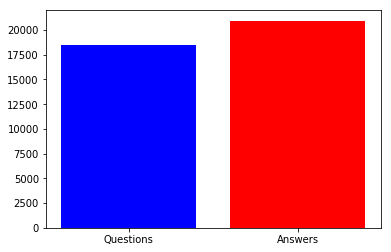

In [10]:
plt.bar(dist.keys(), dist.values(),color=['blue', 'red'])

In [11]:
dist

{'Questions': 18513, 'Answers': 20938}

In [12]:
questions_df.isnull().any()

Id                  False
PostTypeId          False
ParentID             True
AcceptedAnswerId     True
CreationDate        False
Score               False
ViewCount           False
OwnerUserId          True
Tags                False
Title               False
Body                False
dtype: bool

In [13]:
answers_df.isnull().any()

Id                  False
PostTypeId          False
ParentID             True
AcceptedAnswerId     True
CreationDate        False
Score               False
ViewCount            True
OwnerUserId          True
Tags                 True
Title                True
Body                False
dtype: bool

In [14]:
tag_rows = []
cols = ["Id","Tag"]
for index, row in data_posts.iterrows():
    pid = row['Id']
    tag = row['Tags']
    if tag is not None:
        tags = re.split('><|>|<',tag) 
        for t in tags:
            if len(t.strip())>0:
                tag_rows.append({"Id":pid,"Tag":t})
    else:
        tag_rows.append({"Id":pid,"Tag":None})
data_tags = pd.DataFrame(tag_rows, columns = cols)

In [15]:
data_tags.head()

,Id,Tag
0,5,machine-learning
1,7,education
2,7,open-source
3,9,None
4,10,None


In [16]:
data_posts_part = data_posts[['Id','PostTypeId','CreationDate','Score','ViewCount','AcceptedAnswerId','ParentID','OwnerUserId']]
data_posts_part['CreationDate'] = pd.to_datetime(data_posts_part['CreationDate'], format="%Y-%m-%d %H:%M:%S")
data_posts_part['YearCreated'] = data_posts_part.CreationDate.dt.year
data_posts_part.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,AcceptedAnswerId,ParentID,OwnerUserId,YearCreated
0,5,1,2014-05-13 23:58:30.457,8,604,None,None,5,2014
1,7,1,2014-05-14 00:11:06.457,4,426,10,None,36,2014
2,9,2,2014-05-14 00:36:31.077,5,None,None,None,51,2014
3,10,2,2014-05-14 00:53:43.273,12,None,None,None,22,2014
4,14,1,2014-05-14 01:25:59.677,23,1495,29,None,66,2014


In [17]:
data_posts_temp = pd.merge(data_posts_part, data_tags, on='Id',  how='right')

In [18]:
data_posts_temp[['Id','YearCreated','Tag']][data_posts_temp['Tag'].notna()].head()

,Id,YearCreated,Tag
0,5,2014,machine-learning
1,7,2014,education
2,7,2014,open-source
5,14,2014,data-mining
6,14,2014,definitions


In [19]:
data_posts_temp.shape

(75368, 10)

In [20]:
data_posts_temp_gp = data_posts_temp.groupby(['Tag','YearCreated']).size().reset_index()
data_posts_temp_gp.columns=['Tag','YearCreated','Pop']

In [21]:
data_posts_temp_gp['Tag'].nunique()

489

In [22]:
data_posts_temp_gp.head()

,Tag,YearCreated,Pop
0,.net,2014,1
1,.net,2015,1
2,.net,2016,1
3,.net,2017,2
4,.net,2019,1


In [23]:
rep = data_posts_temp_gp.groupby('Tag')['YearCreated'].agg(['count']).reset_index()
print(rep.shape)
rep.head()

(489, 2)


,Tag,count
0,.net,5
1,3d-reconstruction,1
2,ab-test,6
3,accuracy,6
4,activation,1


In [24]:
data_posts_temp_gp = pd.merge(data_posts_temp_gp, rep, on='Tag',  how='left')
data_posts_temp_gp.head()

,Tag,YearCreated,Pop,count
0,.net,2014,1,5
1,.net,2015,1,5
2,.net,2016,1,5
3,.net,2017,2,5
4,.net,2019,1,5


#### Remove all Tags that only appeared in 2 of the 6 year period under consideration

In [25]:
data_posts_temp_gp = data_posts_temp_gp[data_posts_temp_gp['count']>2]
data_posts_temp_gp.head()

,Tag,YearCreated,Pop,count
0,.net,2014,1,5
1,.net,2015,1,5
2,.net,2016,1,5
3,.net,2017,2,5
4,.net,2019,1,5


#### Extract each year of the data

In [26]:
data_posts_temp_gp_14 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2014]
#data_posts_temp_gp_14 = data_posts_temp_gp_14.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_14 = data_posts_temp_gp_14[data_posts_temp_gp_14['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_14.shape)
data_posts_temp_gp_14.head()

(142, 4)


,Tag,YearCreated,Pop,count
0,.net,2014,1,5
6,ab-test,2014,2,6
12,accuracy,2014,9,6
42,algorithms,2014,27,6
64,anomaly-detection,2014,2,6


In [27]:
data_posts_temp_gp_15 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2015]
#data_posts_temp_gp_15 = data_posts_temp_gp_15.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_15 = data_posts_temp_gp_15[data_posts_temp_gp_15['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_15.shape)
data_posts_temp_gp_15.head()

(211, 4)


,Tag,YearCreated,Pop,count
1,.net,2015,1,5
7,ab-test,2015,1,6
13,accuracy,2015,3,6
23,active-learning,2015,1,4
32,aggregation,2015,1,5


In [28]:
data_posts_temp_gp_16 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2016]
#data_posts_temp_gp_16 = data_posts_temp_gp_16.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_16 = data_posts_temp_gp_16[data_posts_temp_gp_16['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_16.shape)
data_posts_temp_gp_16.head()

(259, 4)


,Tag,YearCreated,Pop,count
2,.net,2016,1,5
8,ab-test,2016,11,6
14,accuracy,2016,14,6
19,activation-function,2016,2,4
33,aggregation,2016,2,5


In [29]:
data_posts_temp_gp_17 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2017]
#data_posts_temp_gp_17 = data_posts_temp_gp_17.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_17 = data_posts_temp_gp_17[data_posts_temp_gp_17['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_17.shape)
data_posts_temp_gp_17.head()

(314, 4)


,Tag,YearCreated,Pop,count
3,.net,2017,2,5
9,ab-test,2017,7,6
15,accuracy,2017,17,6
20,activation-function,2017,9,4
24,active-learning,2017,1,4


In [30]:
data_posts_temp_gp_18 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2018]
#data_posts_temp_gp_18 = data_posts_temp_gp_16.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_18 = data_posts_temp_gp_18[data_posts_temp_gp_18['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_18.shape)
data_posts_temp_gp_18.head()

(322, 4)


,Tag,YearCreated,Pop,count
10,ab-test,2018,2,6
16,accuracy,2018,49,6
21,activation-function,2018,25,4
25,active-learning,2018,2,4
30,actor-critic,2018,4,3


In [31]:
data_posts_temp_gp_19 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2019]
#data_posts_temp_gp_19 = data_posts_temp_gp_19.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_19 = data_posts_temp_gp_19[data_posts_temp_gp_19['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_19.shape)
data_posts_temp_gp_19.head()

(325, 4)


,Tag,YearCreated,Pop,count
4,.net,2019,1,5
11,ab-test,2019,3,6
17,accuracy,2019,60,6
22,activation-function,2019,32,4
26,active-learning,2019,4,4


#### Plot progression of Tag popularity over the 6 year period

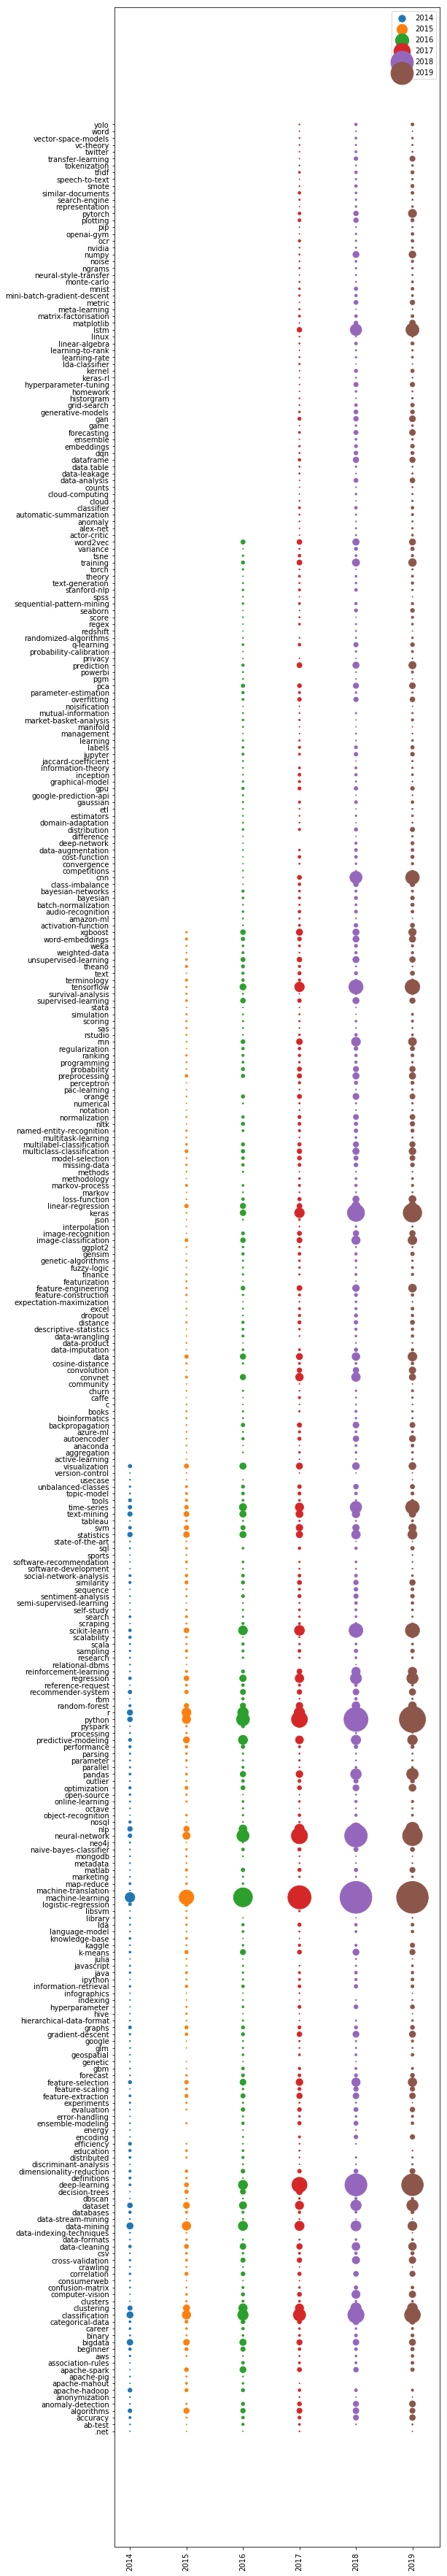

In [32]:
%matplotlib inline
plt.subplots(figsize = (8,64))
plt.scatter(data_posts_temp_gp_14.YearCreated,data_posts_temp_gp_14.Tag,  s=data_posts_temp_gp_14.Pop,  label='2014')
plt.scatter(data_posts_temp_gp_15.YearCreated,data_posts_temp_gp_15.Tag,  s=data_posts_temp_gp_15.Pop,  label='2015')
plt.scatter(data_posts_temp_gp_16.YearCreated,data_posts_temp_gp_16.Tag,  s=data_posts_temp_gp_16.Pop,  label='2016')
plt.scatter(data_posts_temp_gp_17.YearCreated,data_posts_temp_gp_17.Tag,  s=data_posts_temp_gp_17.Pop,  label='2017')
plt.scatter(data_posts_temp_gp_18.YearCreated,data_posts_temp_gp_18.Tag,  s=data_posts_temp_gp_18.Pop,  label='2018')
plt.scatter(data_posts_temp_gp_19.YearCreated,data_posts_temp_gp_19.Tag,  s=data_posts_temp_gp_19.Pop,  label='2019')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [33]:
interest = ['classification','deep-learning','machine-learning','neural-network','python','time-series','keras','tensorflow','cnn','matplotlib']
data_posts_temp_int = data_posts_temp_gp[data_posts_temp_gp['Tag'].isin(interest)]

In [34]:
data_posts_temp_int.shape

(53, 4)

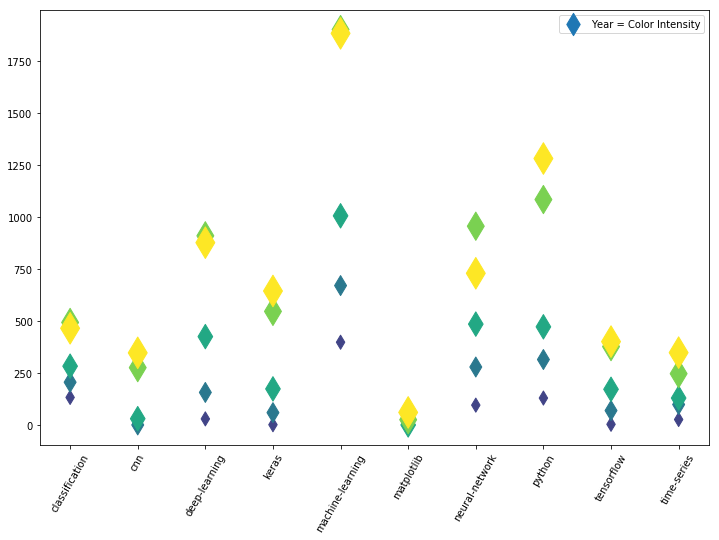

In [35]:
plt.subplots(figsize = (12,8))
plt.scatter(data_posts_temp_int.Tag,data_posts_temp_int.Pop, c=data_posts_temp_int.YearCreated, marker='d', s=(data_posts_temp_int.YearCreated%2014*100), label='Year = Color Intensity')
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [36]:
data_posts_temp_int.head()

,Tag,YearCreated,Pop,count
215,classification,2014,73,6
216,classification,2015,133,6
217,classification,2016,206,6
218,classification,2017,283,6
219,classification,2018,493,6


In [37]:
questions_df.shape

(18513, 11)

In [38]:
questions_df['Body'][0:10]

0     <p>I've always been interested in machine lear...
1     <p>As a researcher and instructor, I'm looking...
4     <p>I am sure data science as will be discussed...
5     <p>In which situations would one system be pre...
6     <p>I use <a href="http://www.csie.ntu.edu.tw/~...
9     <p>Lots of people use the term <em>big data</e...
10    <p>we created this social network application ...
12    <p>My data set contains a number of numeric at...
21    <p>I have a bunch of customer profiles stored ...
23    <p>In working on exploratory data analysis, an...
Name: Body, dtype: object

In [39]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [40]:
tag_list = []

def tokenize(text):
    punc = (string.punctuation).replace('-','')
    table = str.maketrans('', '', punc)
    words = text.split()
    stripped = [w.translate(table) for w in words if len(w.translate(table))>0]
    return stripped

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def load_lines(df):
    document = []
    ps = PorterStemmer()
    comma = ","
    for index, row in df.iterrows():
        body = remove_html_tags(row['Body'])
        title = row['Title']
        tag = row['Tags']
        data = body
        if not title is None:
            data += (comma+title)
            tags = ','.join(re.split('><|>|<',tag.lower()))
            tag_list.append(tags.split(','))
            data += (comma+tags)
        sentences = sent_tokenize(data)
        line = []
        for sent in sentences:
            #sent = re.sub(r'[^\w\s]','',sent)
            all_words = [w.lower() for w in word_tokenize(sent) if w.isalpha()]
            words = [word for word in all_words if word not in stop_words]
            #swords = [ps.stem(word) for word in words]
            uwords = list(Counter(words).keys())
            line += uwords
        if (len(line))>0:
            document.append(line)
    return document

def load_lines_ret(df):
    document = []
    ps = PorterStemmer()
    for index, row in df.iterrows():
        body = remove_html_tags(row['Body'])
        title = row['Title']
        tag = row['Tags']
        data = body
        if not title is None:
            data += title
            tags = ','.join(re.split('><|>|<',tag.lower()))
            tag_list.append(tags.split(','))
            data += tags
        sentences = sent_tokenize(data.lower())
        line = []
        for sent in sentences:
            #sent = re.sub(r'[^\w\s]','',sent)
            all_words = [w for w in tokenize(sent) if w.isalpha()]
            words = [word for word in all_words if word not in stop_words]
            #swords = [ps.stem(word) for word in words]
            uwords = list(Counter(words).keys())
            line += uwords
        document.append(line)
    return document

In [41]:
%%time
docs = list(load_lines(data_posts))

CPU times: user 1min 14s, sys: 203 ms, total: 1min 14s
Wall time: 1min 14s


In [42]:
len(docs)

39786

In [43]:
%%time
model = gensim.models.Word2Vec (docs, size=100, window=10, min_count=1, workers=10)
model.train(docs,total_examples=len(docs),epochs=10)

CPU times: user 1min 43s, sys: 464 ms, total: 1min 44s
Wall time: 22.7 s


(23759444, 24964540)

In [44]:
model.wv.most_similar(positive=["timeseries"], topn=5)

[('forecasting', 0.6582202315330505),
 ('arima', 0.632562518119812),
 ('univariate', 0.6207678914070129),
 ('forecast', 0.6175917387008667),
 ('lag', 0.6114329099655151)]

In [45]:
model.wv.most_similar(positive=["nltk"], topn=5)

[('spacy', 0.8533786535263062),
 ('lemmatizer', 0.7359433174133301),
 ('textblob', 0.733792781829834),
 ('tokenizer', 0.7242674827575684),
 ('tokenizers', 0.7227521538734436)]

In [46]:
model.wv.doesnt_match(["python","r","java","sql","pandas","javascript"])

'pandas'

In [47]:
model.wv.most_similar(positive=['numpy','python'], negative=['library'], topn=1)

[('arrays', 0.4677204191684723)]

In [48]:
print(model)

Word2Vec(vocab=46242, size=100, alpha=0.025)


In [49]:
model.wv.most_similar(positive=["keras"], topn=5)

[('tensorflow', 0.7209618091583252),
 ('pytorch', 0.6589466333389282),
 ('theano', 0.5656622648239136),
 ('convlstm', 0.5310219526290894),
 ('theanos', 0.5184531211853027)]

In [50]:
model.wv.similarity('numpy','array')

0.39790133

In [51]:
word1 = 'matplotlib'
word2 = "javascript"
vocab1 = model.wv.most_similar (positive=[word1],topn=5)
vocab2 = model.wv.most_similar (positive=[word2],topn=5)

In [52]:
v1 = []
for item in vocab1:
    v1.append(item[0])
X1 = model[v1]

v2 = []
for item in vocab2:
    v2.append(item[0])
X2 = model[v2]

In [53]:
tsne = TSNE(n_components=2)
X1_tsne = tsne.fit_transform(X1)
X2_tsne = tsne.fit_transform(X2)

In [54]:
df1 = pd.DataFrame(X1_tsne, index=vocab1, columns=['x', 'y'])
df2 = pd.DataFrame(X2_tsne, index=vocab2, columns=['x', 'y'])

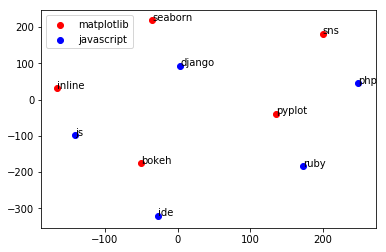

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df1['x'], df1['y'], color='red', label=word1)
ax.scatter(df2['x'], df2['y'], color='blue', label=word2)

for word, pos in df1.iterrows():
    ax.annotate(word[0], pos)
    
for word, pos in df2.iterrows():
    ax.annotate(word[0], pos)
plt.legend()

In [56]:
doc_tag = []
for entry in tag_list:
    tag = [n for n in entry if len(n.strip())>0]
    doc_tag.append(tag)

In [57]:
doc_tag[100]

['open-source', 'dataset', 'crawling']

In [58]:
model_tags = gensim.models.Word2Vec (doc_tag, size=100, window=10, workers=10)
model_tags.train(doc_tag,total_examples=len(doc_tag),epochs=10)

(265279, 539520)

In [59]:
model_tags.wv.most_similar(positive=["visualization"], topn=5)

[('plotting', 0.9722431898117065),
 ('seaborn', 0.967121958732605),
 ('matplotlib', 0.9571316242218018),
 ('tableau', 0.9453781843185425),
 ('ggplot2', 0.9418836832046509)]

In [60]:
popular = ['classification','deep-learning','machine-learning','neural-network','python','time-series','keras','tensorflow','cnn','matplotlib']

In [61]:
G = nx.Graph()
for entry in popular:
    resp = model_tags.wv.most_similar(positive=[entry], topn=5)
    for item in resp:
        G.add_edge(entry, item[0]) 
        resp_inner = model_tags.wv.most_similar(positive=[item[0]], topn=5)
        for inner in resp_inner:
            G.add_edge(item[0], inner[0])

In [62]:
for n in G.nodes():
    G.nodes[n]['degree'] = (len(list(G.neighbors(n))))
    '''
    if n in popular:
        G.nodes[n]['degree'] = 10
    else:
        G.nodes[n]['degree'] = 5
    '''

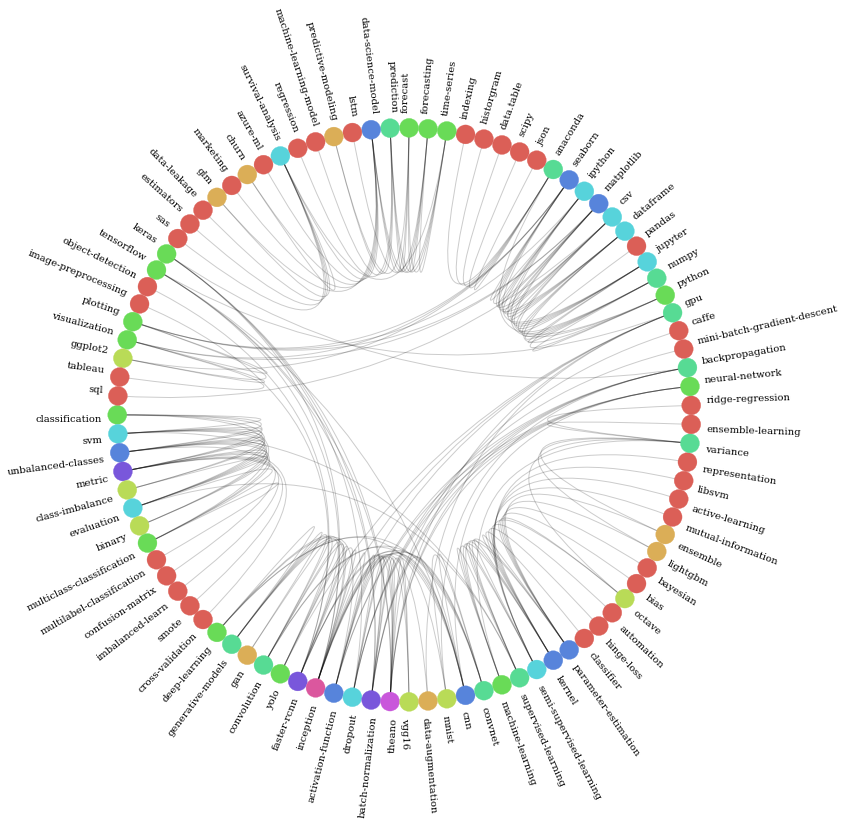

In [63]:
c = nv.CircosPlot(G,node_labels=True, node_color='degree',figsize=(12, 12),node_label_layout="rotation",)
c.draw()
plt.show()

In [64]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'